# Introduction to Machine Learning (CSCI-UA.473)
## Lab 9: Principal Component Analysis and Non-Negative Matrix Factorization
### Date: November 18th, 2021
### Name: (your name goes here)
### Email: (your NYU email goes here)

## Dimensionality Reduction

We are going to learn about implementing a couple of dimensionality reduction techniques and visualizing the results. In particular we will cover: 

1. PCA = Principle Component Analysis
2. NMF = Non-negative Matrix Factorization

As discussed in the lecture the two techniques differ in the constraints they impose on the dictionary elements and the representations, which in-turn leads to a completely different objective function and the optimization algorithm. 

## Principal Component Analysis
We will start with the PCA, which involves computing the projections of the original input so that the reconstruction error is minimized.

$$
\arg \min_{W,Z} \| X - WZ \|^2_F
$$

This is equivalent to maximizing the variance of the projected data and can be efficiently computed by decomposing the data matrix $X$ into its singular values. 

### Load the dataset

We will first load the standard packages and then load and use the b/w faces data set, which is avaialable to download from here: 

https://github.com/HyTruongSon/Pattern-Classification/tree/master/MIT-CBCL-database

Load the standard packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from scipy import linalg
from scipy.sparse import diags
import scipy.optimize

import autograd
from autograd import grad
import autograd.numpy as numpy
import autograd.numpy.random as npr

%matplotlib inline

# the normalize function which first computes the mean 
# and then subtracts it from all the data points
def normalize(data):
    mean = np.mean(data, axis=1)[:,None]
    return data - mean

Load the dataset and display a test image

Input data shape: (2429, 361)


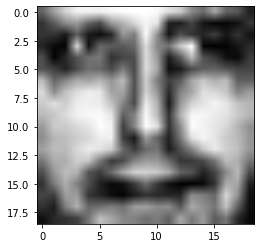

In [3]:
raw_data = open('./svm.train.normgrey').readlines()
X = []

for line in raw_data[2:]:
    if line.strip() == "":
        continue
    if int(line.split()[-1]) == -1:
        # not face, skip
        continue
    else:
        X.append( [float(yy) for yy in line.split()[:-1]] )

X = np.array(X)
print('Input data shape: {}'.format(X.shape))

plt.imshow(X[0].reshape((19, 19)), cmap=cm.gray, interpolation="bilinear")

X = normalize(X)
X = np.transpose(X)
# Why transpose?

Get the size of the original input space and also set the size of the new low-dimensional output space

In [3]:
n_comp = 121  # how many dimensions will be in the new space

(d, N) = X.shape
q = n_comp

print ("d: old dim",  d)
print ("N: num of samples", N)
print ("q: new dim", q)

d: old dim 361
N: num of samples 2429
q: new dim 121


### Compute the Principal Components

We use the Singular Value Decomposition of the matrix X to compute all the components

In [4]:
def train_pca_svd(input_data):
    U, S, V = linalg.svd(X)  # SVD decomposition
    print('Input dimensions: {}'.format(input_data.shape))
    print('Left singular vector matrix shape: {}'.format(U.shape))
    print('Right singular vector matrix shape: {}'.format(V.shape))
    print('Singular value matrix shape: {}'.format(S.shape))
    
    return S, U

In [5]:
S_faces, U_faces = train_pca_svd(X)

Input dimensions: (361, 2429)
Left singular vector matrix shape: (361, 361)
Right singular vector matrix shape: (2429, 2429)
Singular value matrix shape: (361,)


In order to compute the principal components, we take the most impactful columns of the left singular matrix

In [6]:
# take q most impactful columns from U. These are your principal components
top_vectors = U_faces[:, :q]
# reduce dimensionality of our input data by projecting each point onto the principal components
X_reduced = X.transpose() @ top_vectors

In [7]:
# lets check the shape of the old and the new data matrix
np.transpose(X).shape, X_reduced.shape

((2429, 361), (2429, 121))

### Visualization of principle components

(121, 361)


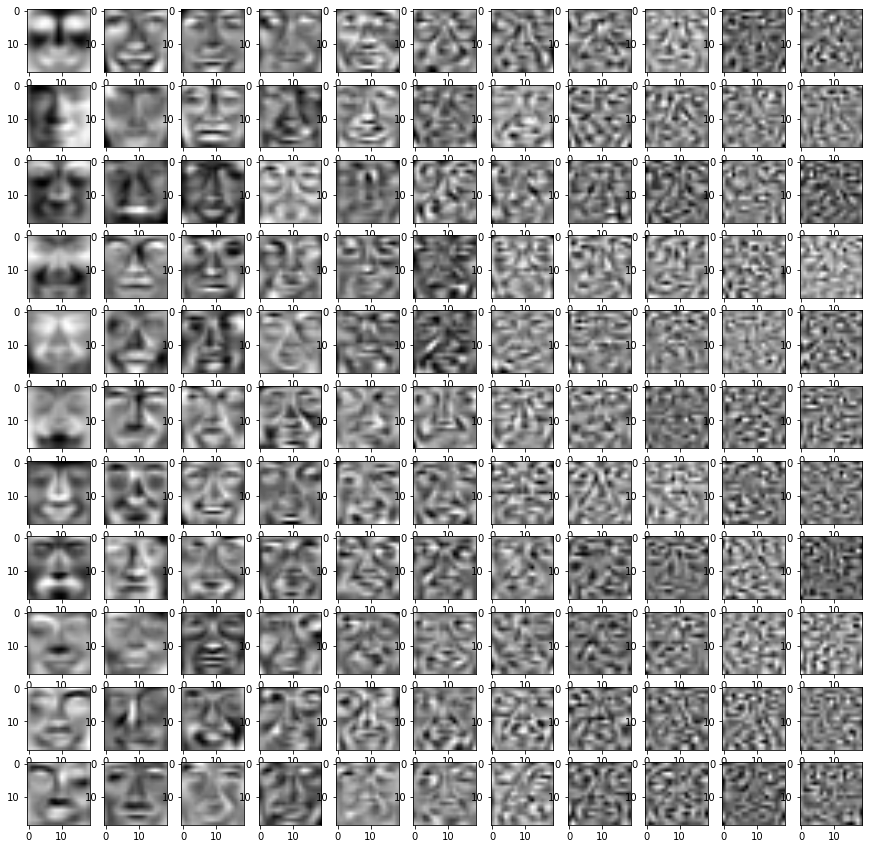

In [8]:
loadings = top_vectors.transpose()
print(loadings.shape)
f, axarr = plt.subplots(int(np.sqrt(n_comp)), int(np.sqrt(n_comp)), figsize = (15, 15))

comp_ix = 0
# loop over the principal components and display them as an image of size 19x19
for j in range(int(np.sqrt(n_comp))):
    for i in range(int(np.sqrt(n_comp))):
        axarr[i, j].imshow(loadings[comp_ix].reshape((19, 19)), cmap=cm.gray, interpolation="bilinear")
        comp_ix += 1

In [9]:
# compute the reconstruction error between the original and reconstructed image
reconstruction_err = np.linalg.norm( X - top_vectors @ np.transpose(X_reduced) )
print ('Reconstructions error: ', reconstruction_err)

Reconstructions error:  38.38769195134055


# Reconstruct the image back from the reduced space

In [10]:
def reconstruct_face(idx):
    original_face = X[:,idx]
    reduced_face = X_reduced[idx]
    reconstructed_face = reduced_face @ loadings

    plt.figure(figsize=(10, 10))
    plt.subplot(1, 3, 1)
    plt.imshow(original_face.reshape((19, 19)), cmap=cm.gray, interpolation="bilinear")

    plt.subplot(1, 3, 3)
    plt.imshow(reconstructed_face.reshape((19, 19)), cmap=cm.gray, interpolation="bilinear")

In [11]:
loadings.shape

(121, 361)

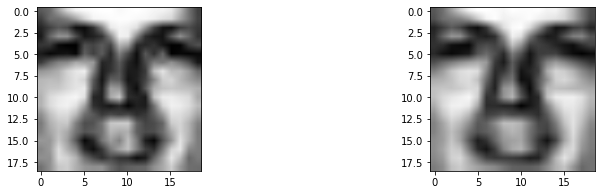

In [12]:
# the reconstructed face does not look that bad
reconstruct_face(20)

## Non-Negative Matrix Factorization (NMF)
The optimization problem for non-negative matrix factorization is similar to the PCA, except it has additional non-negativity constraints on $W$ and $Z$. 

$$
\begin{align}
\arg \min_{W,Z} & \| X - WZ \|^2_F \\
s.t. \quad & w_{ij} \ge 0 \quad i = 1, \ldots, n \quad j = 1, \ldots, p \\
           & z_{ij} \ge 0 \quad i = 1, \ldots, p \quad j = 1, \ldots, n \\
\end{align}
$$

Presence of additional constraints makes the optimization problem a little harder.

In [13]:
def train_nmf(input_data):
    multiplicative = True
    maxiter = 1000
    X = input_data
    W = np.real( (np.random.rand(d,q))*0.5 )
    Z = np.real( (np.random.rand(q,N))*0.5 )
    print ('start optimising...')
    # X : (d, N)
    # W : (d, q)
    # Z : (q, N)        
    for u_iter in range(maxiter):
        if multiplicative:
            diff = X - W @ Z
            W = W * (X @ np.transpose(Z)) / (W @ Z @ np.transpose(Z))
            Z = Z * (np.transpose(W) @ X) / (np.transpose(W) @ W @ Z)
        else:
            diff = X - W @ Z
            lr = 0.001
            W_ = W + lr * (diff) @ np.transpose(Z)
            Z_ = Z + lr * np.transpose(W) @ (diff)       
            W, Z = np.maximum(W_, 0, W_), np.maximum(Z_, 0, Z_)

        if u_iter % 100 == 0:
            print (autograd.numpy.linalg.norm(diff))
        
    print ('optimization finished')
    return W, Z

In [14]:
X = X - np.min(X)  # why do we do that?
#* Answer: normalization

loadings, X_reduced = train_nmf(X)

start optimising...
6620.904565028206
87.27380317525677
70.957519355032
65.41238216285208
62.44634257483283
60.57260108719249
59.25640913592273
58.26675459667458
57.484729101724476
56.84587370464141
optimization finished


In [15]:
loadings = loadings.transpose()

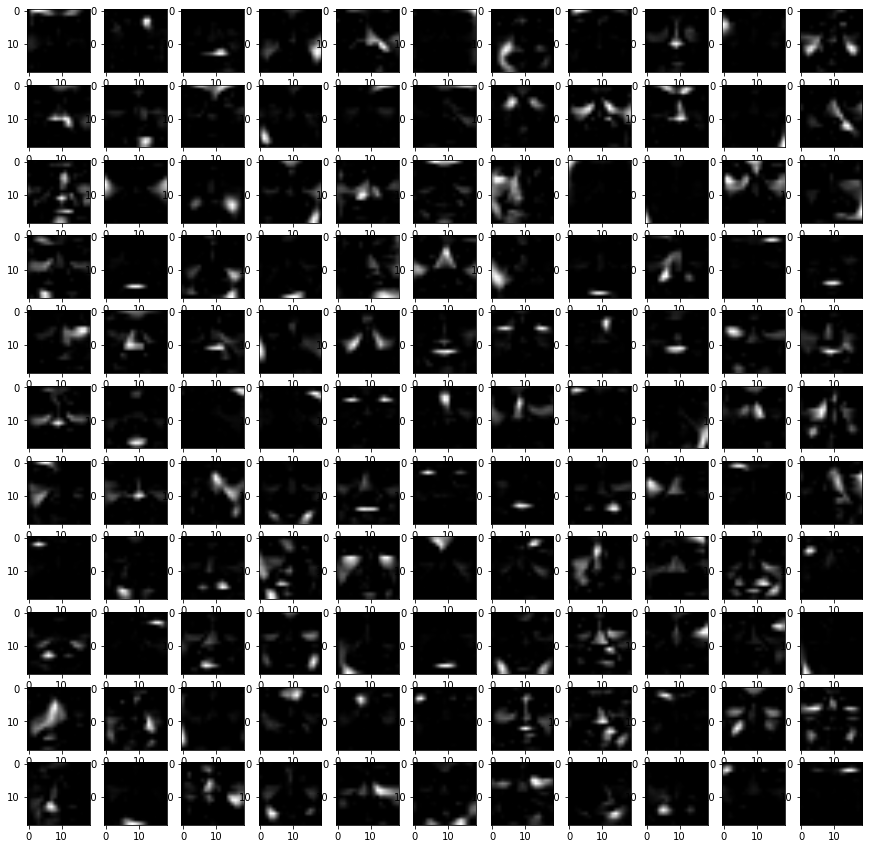

In [16]:
# visualize the factorization learnt
f, axarr = plt.subplots(int(np.sqrt(n_comp)), int(np.sqrt(n_comp)), figsize = (15, 15))

comp_ix = 0
for j in range(int(np.sqrt(n_comp))):
    for i in range(int(np.sqrt(n_comp))):
        axarr[i, j].imshow(loadings[comp_ix].reshape((19, 19)), cmap=cm.gray, interpolation="bilinear")
        comp_ix += 1

## Featurizing text data and reducing its dimensionality

Load the data first. Each document will be a training sample and it will be represented as a tf-idf vector. Tf-idf which is an abbreviation of **Term Frequency Inverse Document Frequency** and its definition is provided here: https://en.wikipedia.org/wiki/Tf%E2%80%93idf  

### Issue: 

Some very frequent words carry very little info: (e.g. the, a, is).

### Solution: 

Reduce dimensionality to remove these frequent words 

What tf-idf does
* If a word occurs in every doc, it means little 

In [17]:
from sklearn import datasets
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

newsgroups_train = datasets.fetch_20newsgroups(subset='train',
                                               categories=[
                                                   'comp.sys.mac.hardware',
                                                   'rec.motorcycles',
                                                   'sci.med',
                                                   'soc.religion.christian'
                                               ])
tfidf_vectorizer = TfidfVectorizer(min_df=30)  # ignore word w/ frequency < 30
X = tfidf_vectorizer.fit_transform(newsgroups_train.data).toarray()
print(len(tfidf_vectorizer.get_feature_names()))
y = newsgroups_train.target

1771


In [18]:
X = np.transpose(X)

(d, N) = X.shape
q = 5  # our reduced dimension

print ("d: old dim",  d)
print ("N: num of samples", N)
print ("q: new dim", q)

d: old dim 1771
N: num of samples 2369
q: new dim 5


In [19]:
S_text, V_text = train_pca_svd(X)

Input dimensions: (1771, 2369)
Left singular vector matrix shape: (1771, 1771)
Right singular vector matrix shape: (2369, 2369)
Singular value matrix shape: (1771,)


In [20]:
# take q most impactful columns from V
top_vectors = V_text[:, :q]

# reduce dimensionality of our input data
X_reduced = X.transpose() @ top_vectors

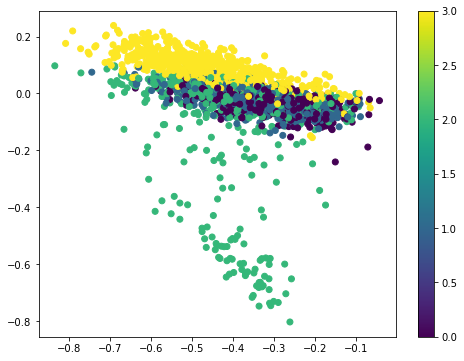

In [21]:
plt.figure(figsize=(8, 6))
plt.scatter(X_reduced[:,0], X_reduced[:, 1], c = y)
plt.colorbar()

In [22]:
loadings = top_vectors.transpose()
invocab = dict([(vv,kk) for kk, vv in tfidf_vectorizer.vocabulary_.items()])
insens_idx = np.argsort(loadings[0])

print ('Top 10 most activated words (loadings)')
for jj in insens_idx[-10:]:
    print ('{} ({:0.6f})'.format(invocab[jj], loadings[0,jj]))
           
    
print ('\n Top 10 least activated words (loadings)')
for jj in insens_idx[:10]:
    print ('{} ({:0.6f})'.format(invocab[jj], loadings[0,jj]))

Top 10 most activated words (loadings)
1st (-0.002503)
typical (-0.002473)
argue (-0.002472)
developed (-0.002462)
51 (-0.002455)
toward (-0.002450)
despite (-0.002425)
mon (-0.002376)
reduce (-0.002355)
58 (-0.002314)

 Top 10 least activated words (loadings)
the (-0.472707)
to (-0.266096)
of (-0.255349)
and (-0.206761)
is (-0.189900)
in (-0.184909)
that (-0.178339)
it (-0.160184)
you (-0.132383)
for (-0.114492)


In [23]:
reconstruction_err = np.linalg.norm( X - top_vectors @ np.transpose(X_reduced) )
print ('Reconstructions error: ', reconstruction_err)

Reconstructions error:  43.35201754483639


### What exactly do the principal components represent? 
What kind of features are being learnt? Lets see. 

In [24]:
invocab = dict([(vv,kk) for kk, vv in tfidf_vectorizer.vocabulary_.items()])

for i in range(q):
    insens_idx = np.argsort(loadings[i])

    print ('COMPONENT ' + str(i))
    print (' '.join([invocab[w_ix] for w_ix in insens_idx[-10:]]) + '\n')

COMPONENT 0
1st typical argue developed 51 toward despite mon reduce 58

COMPONENT 1
bible church christians his jesus we that he the god

COMPONENT 2
ca on my apple mac bike posting host nntp com

COMPONENT 3
what msg do that god your we com to you

COMPONENT 4
cwru thanks drive monitor se god university apple mac edu

